In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive

[Errno 2] No such file or directory: 'drive'
/content/drive/MyDrive/WeatherPredictionProvaVecchia/notebooks


In [ ]:
cd MyDrive

[Errno 2] No such file or directory: 'MyDrive'
/content/drive/MyDrive/WeatherPredictionProvaVecchia/notebooks


In [ ]:
cd WeatherForecastingApp/

[Errno 2] No such file or directory: 'WeatherPredictionProvaVecchia/'
/content/drive/MyDrive/WeatherPredictionProvaVecchia/notebooks


In [ ]:
cd notebooks

[Errno 2] No such file or directory: 'notebooks'
/content/drive/MyDrive/WeatherPredictionProvaVecchia/notebooks


In [ ]:
!pip install feature_engine

# Weather Forecasting App - Data Analysis

In this notebook, we will conduct a preliminary analysis of the dataset. For simplicity, this analysis is not included in the final pipeline, but it can be automated and integrated into the pipeline if needed.






In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    RandomizedSearchCV
)
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, 
    precision_score, 
    recall_score, 
    confusion_matrix, 
    classification_report, 
    f1_score, 
    accuracy_score, 
    mutual_info_score
)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import (
    LabelEncoder, 
    StandardScaler, 
    OneHotEncoder, 
    OrdinalEncoder
)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from imblearn.pipeline import Pipeline as IMBPipeline
from feature_engine.selection import DropFeatures
from joblib import dump, load
from imblearn.over_sampling import SMOTE
import xgboost as xgb

## About the data

The dataset used contains daily weather measurements from weather stations in Seattle *(WeathterForecastingApp/data/seattle-weather.csv*), and the goal is to train the ML models to **predict future weather based on historical data**.
For simplicity, the study is limited to Seattle, but the approach can easily be generalized by using a larger dataset from other regions.

The dataset consists of **1461** entries with **6 columns**:

*   **date**: Day of the observation (Format: *YYYY-MM-DD*)
*   **precipitation**: All forms in which water falls on the land surface and open water bodies as rain, sleet, snow, hail, or drizzle
*  **max_temp and min_temp**: Max and min daily temperatures
*  **wind**: Wind velocity recorded
*  **weather (output)**: Labels describing the weather (e.g., clear, cloudy, rainy).


In [ ]:
# load the data
data = pd.read_csv('../data/seattle-weather.csv')

# print the dimensions of the DataFrame
print(data.shape)

(1461, 6)


A preliminary analysis of the dataset reveals an imbalanced distribution of weather conditions:


*  The **most frequent** conditions are **rain and sun**, with 641 and 640 occurrences, respectively.
*  **Fog** appears 101 times, while **drizzle and snow** are **much less common**, with only 53 and 26 occurrences.




In [ ]:
# check the target variable distribution
data.weather.value_counts()

,count
weather,
rain,641
sun,640
fog,101
drizzle,53
snow,26


In [ ]:
# get the value counts of each unique value in the weather column
weather_counts = data['weather'].value_counts()

# print the percentage of each unique value in the weather column
for weather, count in weather_counts.items():
    percent = (count / len(data)) * 100
    print(f"Percent of {weather.capitalize()}: {percent:.2f}%")

Percent of Rain: 43.87%
Percent of Sun: 43.81%
Percent of Fog: 6.91%
Percent of Drizzle: 3.63%
Percent of Snow: 1.78%


We expect that this disparity in the data could affect model performance, suggesting the need for techniques such as oversampling or class weighting to improve predictions for less frequent weather events.

<ipython-input-61-c7d03fb0ae1f>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


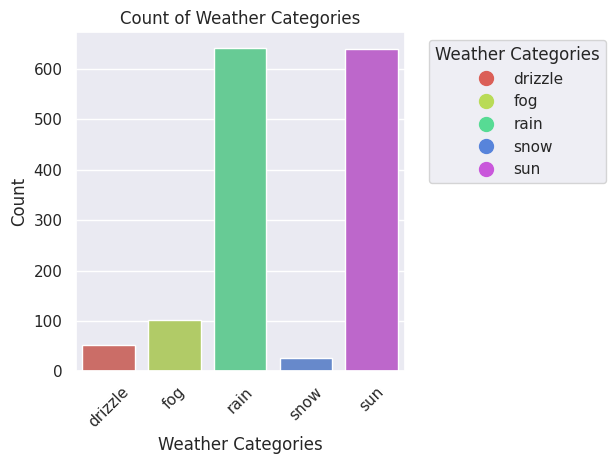

In [ ]:
# create a label encoder object
le = LabelEncoder()

# fit the encoder to the weather column and transform the values
data['weather_encoded'] = le.fit_transform(data['weather'])

# create a dictionary that maps the encoded values to the actual names
weather_names = dict(zip(le.transform(le.classes_), le.classes_))

# define a color palette
palette = sns.color_palette("hls", len(weather_names))

# create the countplot
ax = sns.countplot(
    x='weather_encoded',
    data=data,
    palette=palette
)

# set x-ticks and labels
ax.set_xticks(range(len(weather_names)))
ax.set_xticklabels(weather_names.values(), rotation=45)
ax.set_title("Count of Weather Categories")
ax.set_xlabel("Weather Categories")
ax.set_ylabel("Count")

# add a legend for the colors
legend_labels = [
    plt.Line2D([0], [0], marker='o', color=palette[i], linestyle='', markersize=10, label=label)
    for i, label in enumerate(weather_names.values())
]
plt.legend(handles=legend_labels, title="Weather Categories", bbox_to_anchor=(1.05, 1), loc='upper left')

# show the plot
plt.tight_layout()
plt.show()

The precipitation, temp_max, temp_min, and wind columns are of type float64, while date and weather are object types.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             1461 non-null   object 
 1   precipitation    1461 non-null   float64
 2   temp_max         1461 non-null   float64
 3   temp_min         1461 non-null   float64
 4   wind             1461 non-null   float64
 5   weather          1461 non-null   object 
 6   weather_encoded  1461 non-null   int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 80.0+ KB


The dataset spans from January 1, 2012, to December 31, 2015, and contains daily weather data for Seattle. The average precipitation is around 3.03 mm, with the highest recorded at 55.9 mm while temperature ranges from -7.1°C to 35.6°C, and wind speeds vary between 0.4 m/s and 9.5 m/s.

In [ ]:
data.describe()

,precipitation,temp_max,temp_min,wind,weather_encoded
count,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136,2.752225
std,6.680194,7.349758,5.023004,1.437825,1.191380
min,0.000000,-1.600000,-7.100000,0.400000,0.000000
25%,0.000000,10.600000,4.400000,2.200000,2.000000
50%,0.000000,15.600000,8.300000,3.000000,2.000000
75%,2.800000,22.200000,12.200000,4.000000,4.000000
max,55.900000,35.600000,18.300000,9.500000,4.000000


Upon reviewing the dataset, it was found that there are no missing values in any of the columns. Specifically, the columns for date, precipitation, temp_max, temp_min, wind, and weather **are all complete**.

In [ ]:
def check_missing_value(data):
    columns = data.columns
    for column in columns:
      missing_values = data[column].isnull().sum()
      if missing_values > 0:
         print(f"There are {missing_values} missing values in the column {column}.")
      else:
         print(f"There are no missing values in the column {column}.")

check_missing_value(data)

There are no missing values in the column date.
There are no missing values in the column precipitation.
There are no missing values in the column temp_max.
There are no missing values in the column temp_min.
There are no missing values in the column wind.
There are no missing values in the column weather.
There are no missing values in the column weather_encoded.


### KDE curves

* For the maximum temperature, the distribution is nearly normal with a slight negative skew, meaning most days fall within the 10°C to 25°C range. Similarly, the minimum temperature also exhibits a nearly normal distribution but with a mild positive skew, with most values between 0°C and 15°C.  They appear well-distributed and balanced, requiring less preprocessing.
* The precipitation values are highly positively skewed, with most days having low or no precipitation and only a few instances of extreme rainfall.
* Wind speed data follows a positive skew, similar to precipitation, with most values being low and a few extreme highs.





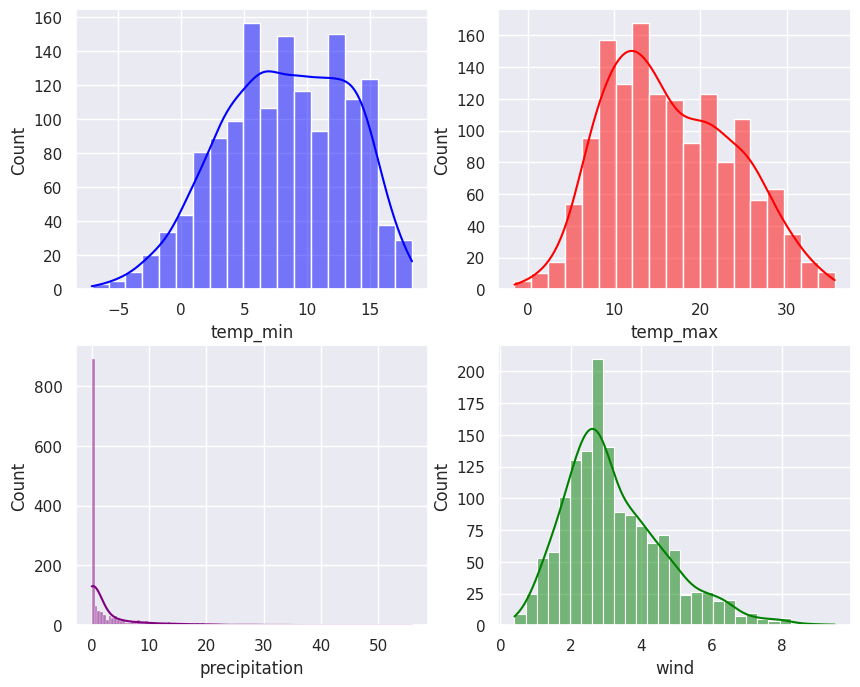

In [ ]:
sns.set(style="darkgrid")

# Define the variables and colors for the subplots
variables = ["temp_min", "temp_max", "precipitation", "wind"]
colors = ["blue", "red", "purple", "green"]

# Create the subplots using a loop
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, var in enumerate(variables):
    sns.histplot(data=data, x=var, kde=True, ax=axs[i//2, i%2], color=colors[i])

### Correlation #1

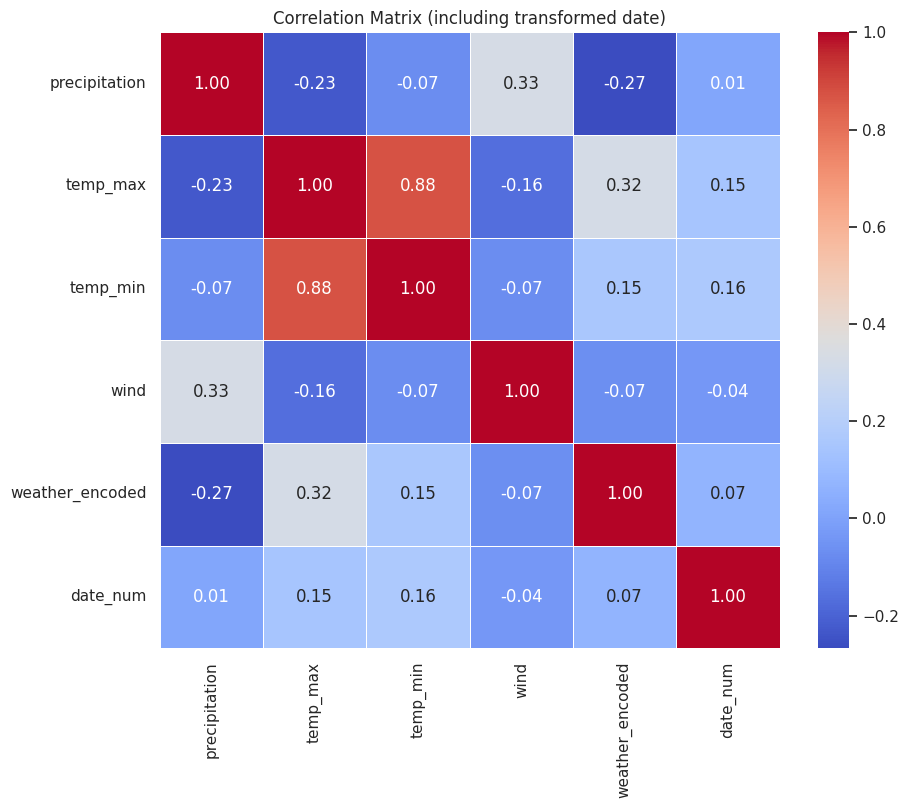

In [ ]:
# convert the date column to datetime format (if it is not already in datetime format)
data['date'] = pd.to_datetime(data['date'])

# create a new column with the number of days elapsed since the minimum date
data['date_num'] = (data['date'] - data['date'].min()).dt.days

# select only the numerical columns of the dataframe
numerical_data = data.select_dtypes(include=['float64', 'int64'])

# calculate the correlation between the date column (converted) and the other numerical variables
correlation_with_date = numerical_data.corrwith(data['date_num'])

# include the 'date_num' column in the correlation matrix
correlation_matrix = numerical_data.assign(date_num=data['date_num']).corr()

# visualize the correlation matrix with a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix (including transformed date)')
plt.show()


*   **Maximum and Minimum Temperatures:** the relationship between temp_max and temp_min shows a strong positive correlation, as expected. Maximum and minimum temperatures tend to move similarly (linearly), which is common in meteorological data.
*   **Precipitation:** precipitation does not appear to have a strong correlation with other variables such as temperatures (temp_max or temp_min) or wind (wind).
However, there are a few **outliers with very high precipitation values**. These could represent extreme events worth further analysis.
*  **Wind (wind):**there is no evident correlation between wind and other variables like temperature or precipitation. It may be influenced by other external factors not represented in the dataset.


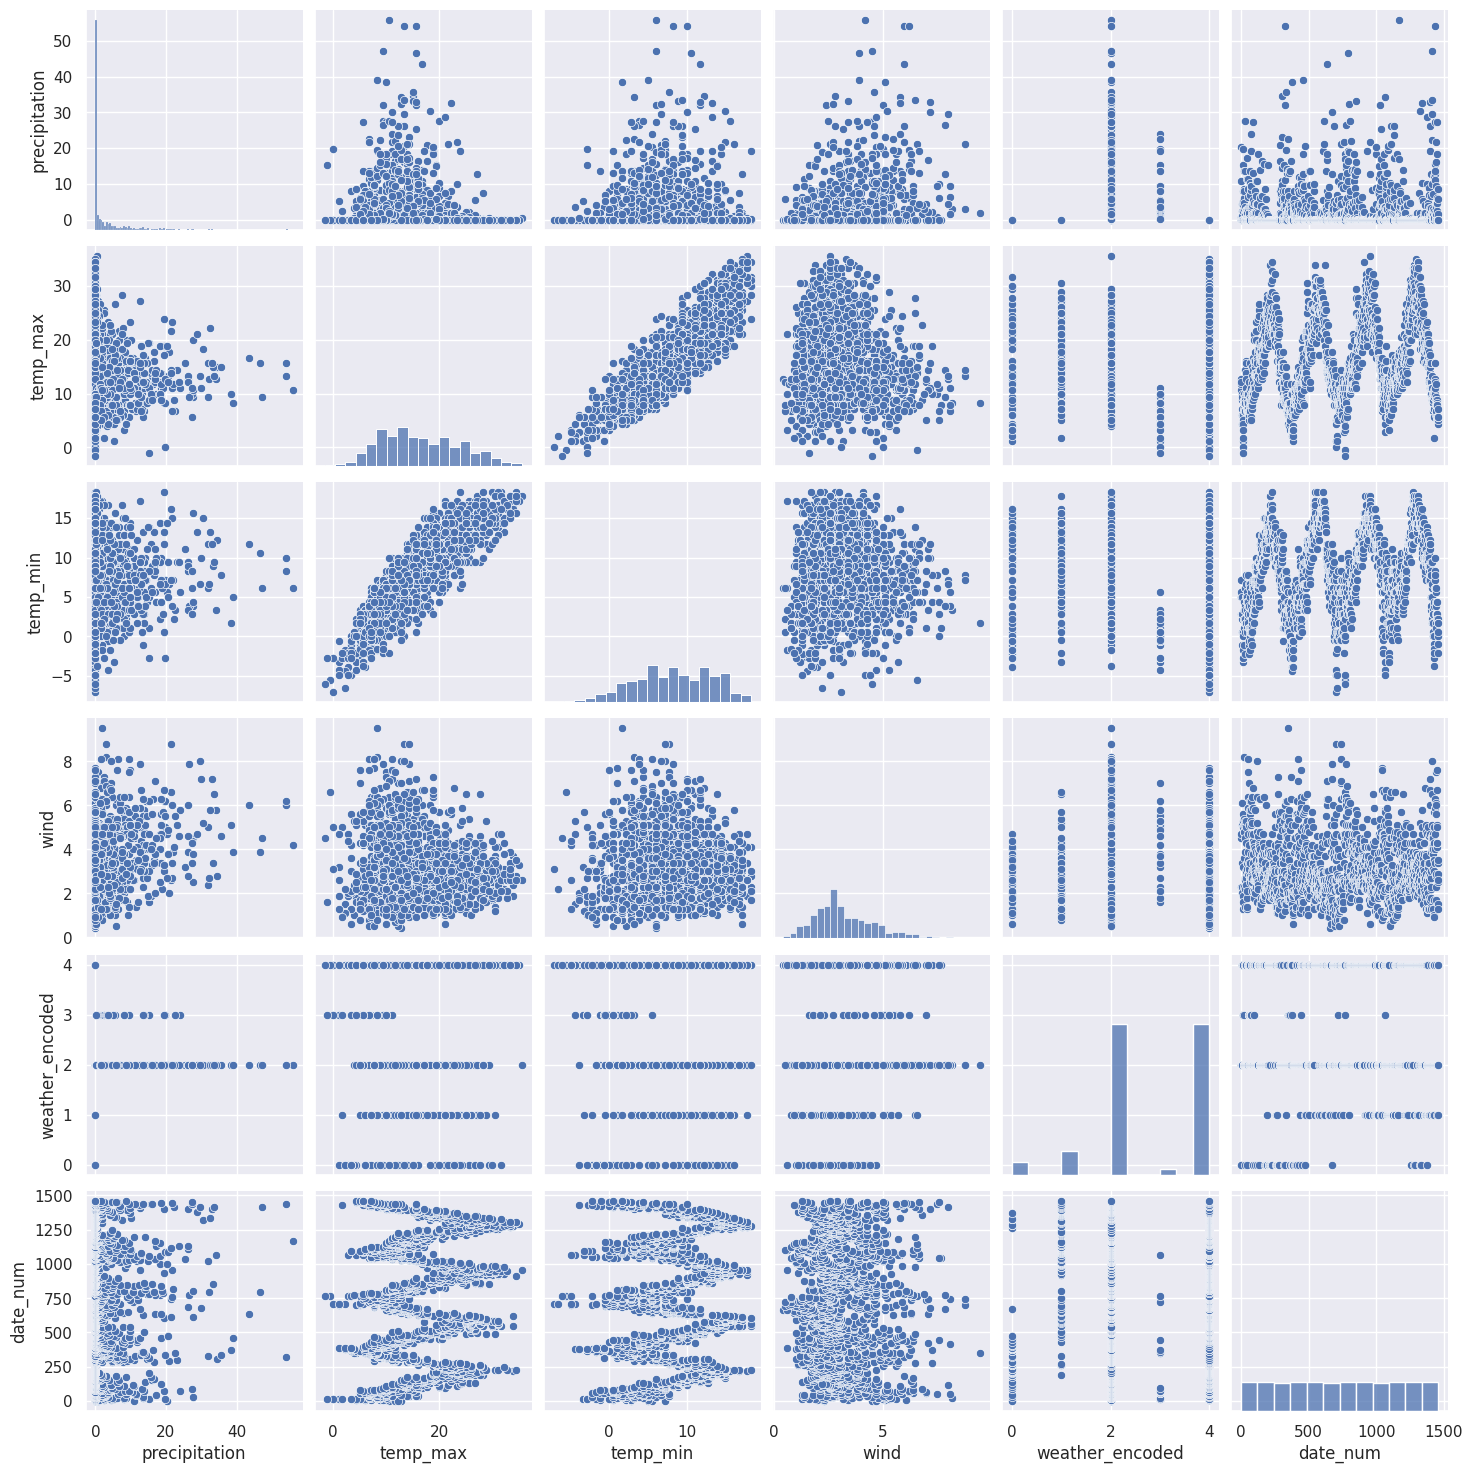

In [ ]:
sns.pairplot(data)
plt.show()

[Text(0.5, 1.0, 'Scatter plot of Maximum vs. Minimum Temperature')]

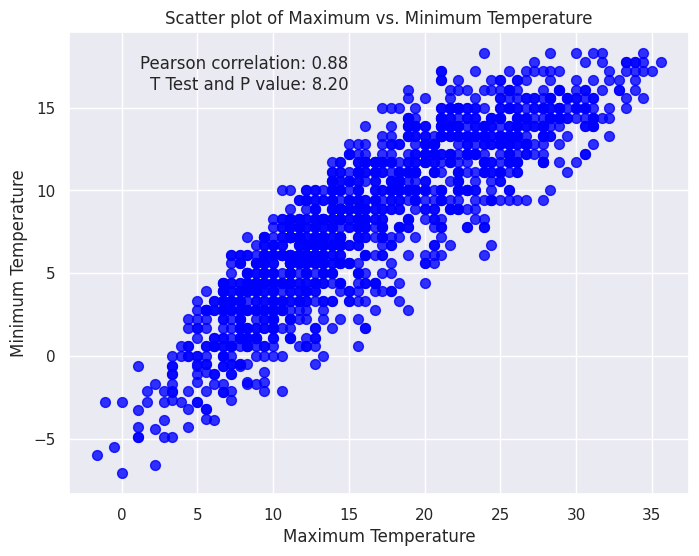

In [ ]:
# create a scatter plot with custom markers and colors, and specify axis object explicitly
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x=data["temp_max"], y=data["temp_min"], marker='o', s=50, alpha=0.8, color='blue')

# calculate Pearson correlation coefficient and p-value
corr, p_value = np.corrcoef(data["temp_max"], data["temp_min"])[0, 1], np.mean(np.abs(np.subtract(data["temp_max"], data["temp_min"])))

# display the correlation and p-value on the plot
ax.text(0.45, 0.95, f"Pearson correlation: {corr:.2f}\nT Test and P value: {p_value:.2f}", transform=ax.transAxes, ha='right', va='top', fontsize=12)

# add labels to the x and y axis
ax.set(xlabel='Maximum Temperature', ylabel='Minimum Temperature')

# add a title to the plot
ax.set(title='Scatter plot of Maximum vs. Minimum Temperature')

[Text(0.5, 1.0, 'Scatter plot of precipitation vs. Minimum Temperature')]

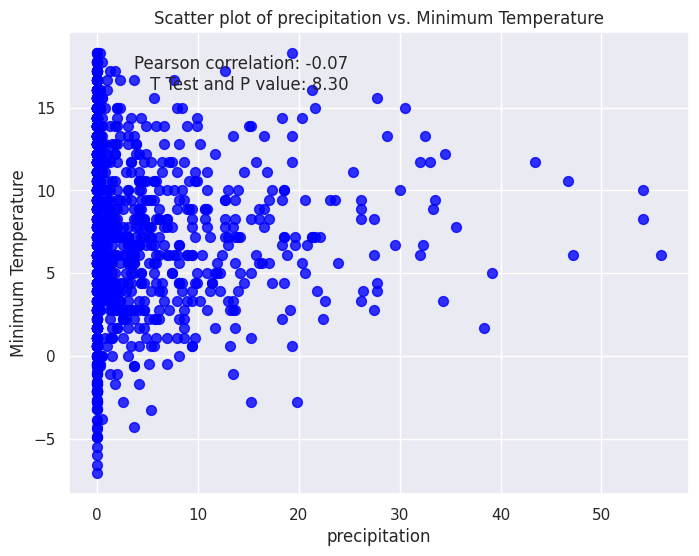

In [ ]:
# create a scatter plot with custom markers and colors, and specify axis object explicitly
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x=data["precipitation"], y=data["temp_min"], marker='o', s=50, alpha=0.8, color='blue')

# calculate Pearson correlation coefficient and p-value
corr, p_value = np.corrcoef(data["precipitation"], data["temp_min"])[0, 1], np.mean(np.abs(np.subtract(data["precipitation"], data["temp_min"])))

# display the correlation and p-value on the plot
ax.text(0.45, 0.95, f"Pearson correlation: {corr:.2f}\nT Test and P value: {p_value:.2f}", transform=ax.transAxes, ha='right', va='top', fontsize=12)

# add labels to the x and y axis
ax.set(xlabel='precipitation', ylabel='Minimum Temperature')

# add a title to the plot
ax.set(title='Scatter plot of precipitation vs. Minimum Temperature')

### Outliers

Outliers in variables such as precipitation and wind can significantly distort data analysis or affect the performance of predictive models. Removing extreme values ensures that the dataset reflects typical patterns rather than anomalies.

<ipython-input-70-0672ec38bcf1>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="precipitation", y="weather", data=data, palette="winter", ax=ax)


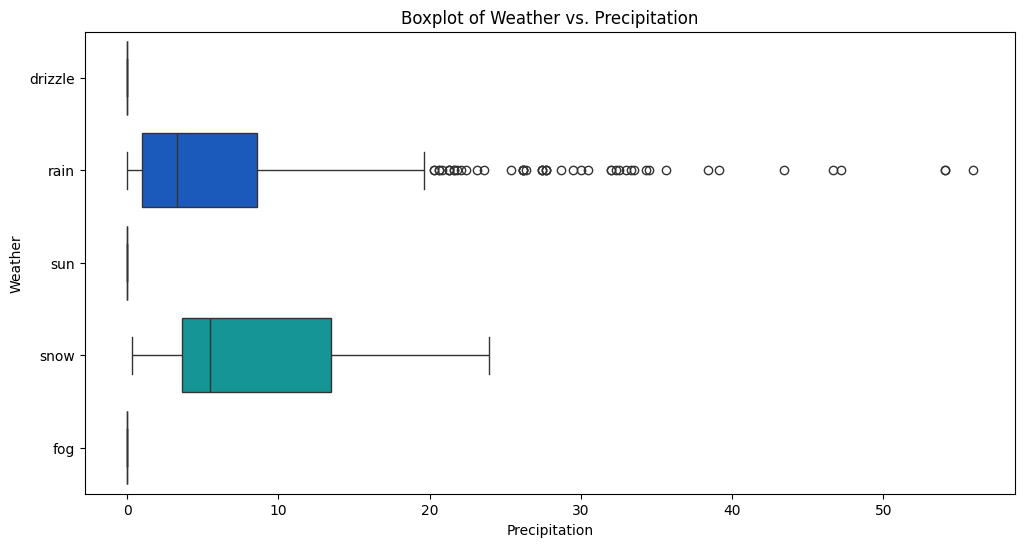

In [ ]:
with plt.style.context('default'):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.boxplot(x="precipitation", y="weather", data=data, palette="winter", ax=ax)
    ax.set(xlabel='Precipitation', ylabel='Weather', title='Boxplot of Weather vs. Precipitation')

<ipython-input-71-8311b1f526b0>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="temp_max", y="weather", data=data, palette="spring", ax=ax)


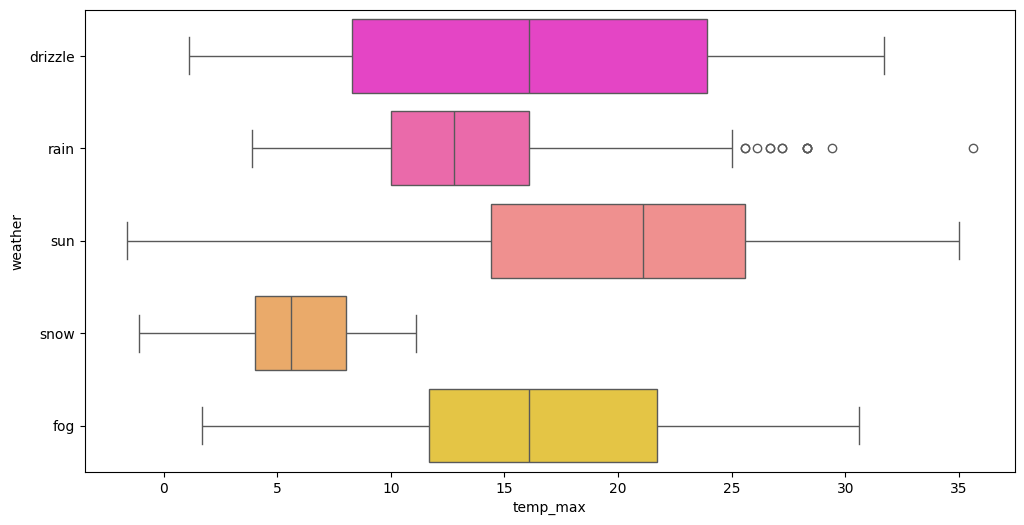

In [ ]:
with plt.style.context('default'):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.boxplot(x="temp_max", y="weather", data=data, palette="spring", ax=ax)

<ipython-input-72-031f230c8b51>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="wind", y="weather", data=data, palette="summer", ax=ax)


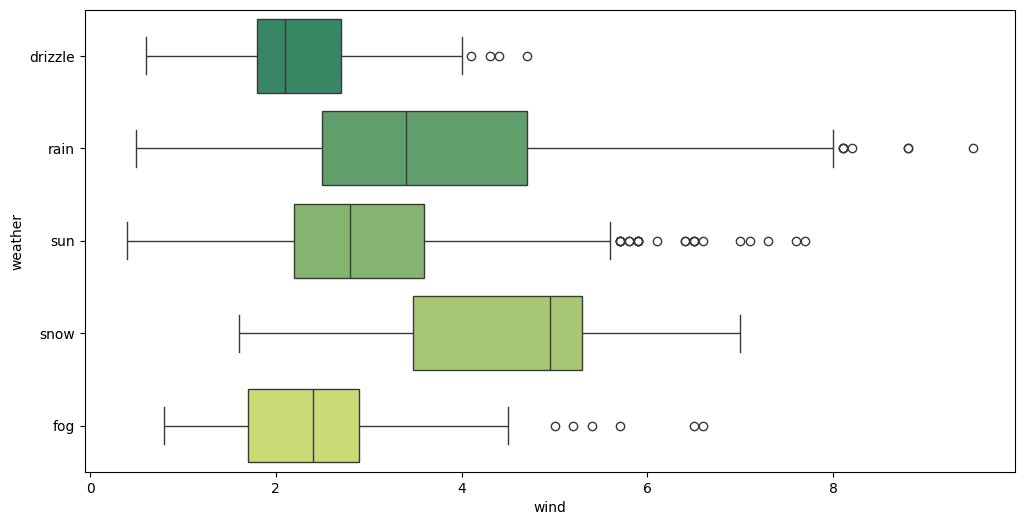

In [ ]:
with plt.style.context('default'):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.boxplot(x="wind", y="weather", data=data, palette="summer", ax=ax)

<ipython-input-73-c5f553a3edf2>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="temp_min", y="weather", data=data, palette="autumn", ax=ax)


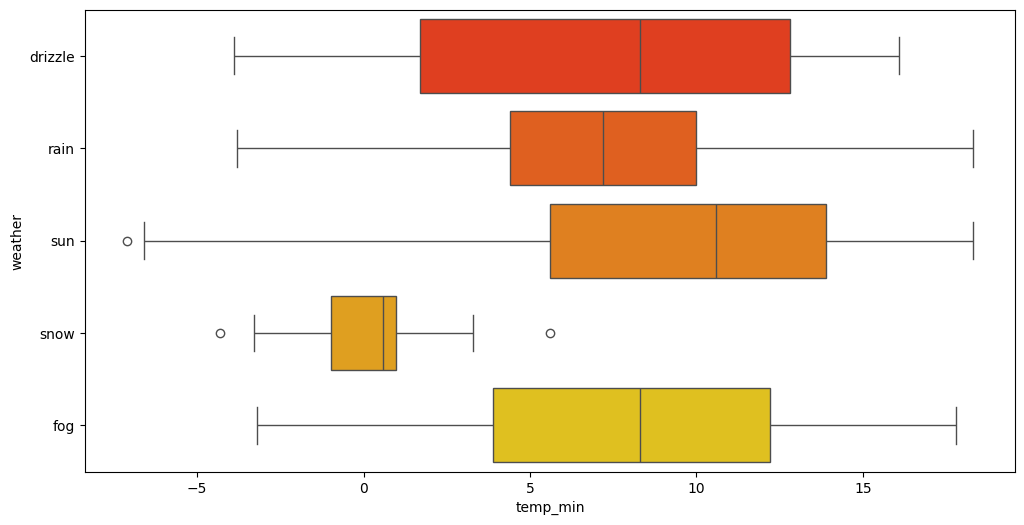

In [ ]:
with plt.style.context('default'):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.boxplot(x="temp_min", y="weather", data=data, palette="autumn", ax=ax)

Some extreme values are observed in the precipitation variable and, to a lesser extent, in the wind variable. Identifying them in the original data could help determine whether they are real or anomalies.

# DATA PREPROCESSING


The excessive presence of outliers, as observed during initial experiments, significantly hindered the model’s ability to learn effectively. These anomalies distorted the learning process and negatively impacted classification performance, as reflected in the evaluation metrics and test set results. Despite reducing the dataset size even further—thereby reinforcing expectations of a less-than-perfect model—removing the outliers proved necessary.

In [ ]:
# define the function for outliers removing
def remove_outliers(df, columns, multiplier=1.5):
    for col in columns:
        Q1 = df[col].quantile(0.25)  # First quartile (25th percentile)
        Q3 = df[col].quantile(0.75)  # Third quartile (75th percentile)
        IQR = Q3 - Q1               # Interquartile range
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR

        # filter out rows with outliers in the specified column
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    return df

# load the dataset
file_path = "../data/seattle-weather.csv"

data = pd.read_csv(file_path)

# identify numerical columns for outlier removal
numerical_columns = data.select_dtypes(include=[np.number]).columns.tolist()

# remove outliers
cleaned_data = remove_outliers(data, numerical_columns)

# save the cleaned data to a new CSV file
output_file = "../data/seattle-weather-cleaned.csv"
cleaned_data.to_csv(output_file, index=False)
print(f"Cleaned dataset saved to {output_file}")


Cleaned dataset saved to ../data/seattle-weather-cleaned.csv


Let's now decompose the date information into multiple subcomponents to analyze whether the model can extract useful insights from these features.

By breaking down the date into elements such as month, day, year, or even additional derived features, we can investigate if these attributes contribute meaningfully to the model’s predictive performance. This approach helps determine whether temporal patterns exist in the data that can enhance the model's ability to identify trends or make accurate predictions.


In [ ]:
# load the data without outliers
data = pd.read_csv('../data/seattle-weather-cleaned.csv')

# print the dimensions of the DataFrame
print(data.shape)

(1211, 6)


In [ ]:
# separating Day, Month and Year
data['date'] = pd.to_datetime(data['date'])
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year

In [ ]:
data.head()

,date,precipitation,temp_max,temp_min,wind,weather,day,month,year
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle,1,1,2012
1,2012-01-03,0.8,11.7,7.2,2.3,rain,3,1,2012
2,2012-01-05,1.3,8.9,2.8,6.1,rain,5,1,2012
3,2012-01-06,2.5,4.4,2.2,2.2,rain,6,1,2012
4,2012-01-07,0.0,7.2,2.8,2.3,rain,7,1,2012


### Correlation #2

The correlation matrix reveals that the decomposed date features (month, day, and year) show **very weak correlations** with other numerical variables in the dataset. Specifically:


* **Month:** The correlation with other variables (e.g., precipitation, temperature, wind, weather_encoded) is minimal, with all correlation values close to zero, indicating it may not provide strong predictive power.
* **Day:** The day feature also shows negligible correlations with all other variables, suggesting it lacks any significant pattern or trend that could enhance the model's predictive accuracy.
* **Year:** The year feature shows slightly higher correlations compared to month and day but remains weak overall, with no substantial relationship to key variables.




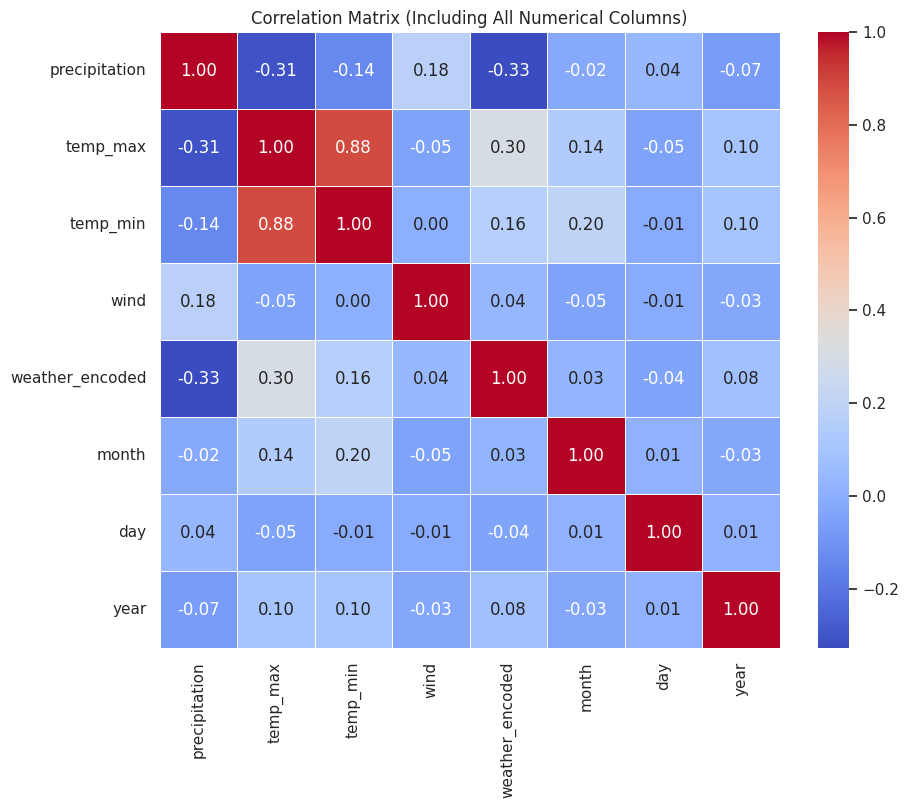

In [ ]:
# ensure 'weather_encoded' is part of the data
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['weather_encoded'] = le.fit_transform(data['weather'])  # Encode the weather column

# ensure 'month', 'day', and 'year' are explicitly added as numerical columns
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['year'] = data['date'].dt.year

# select all numerical columns, including 'month', 'day', 'year', and 'weather_encoded'
num_df = data[['precipitation', 'temp_max', 'temp_min', 'wind', 'weather_encoded', 'month', 'day', 'year']]

# recalculate the correlation matrix including all numerical columns
plt.figure(figsize=(10, 8))
sns.heatmap(num_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix (Including All Numerical Columns)')
plt.show()


## Date's informations/output study

**Seasonal patterns** are clearly visible, with sunny weather peaking in summer and rainy conditions dominating in winter. **Snow** and **fog** are less frequent and **seasonally restricted**.

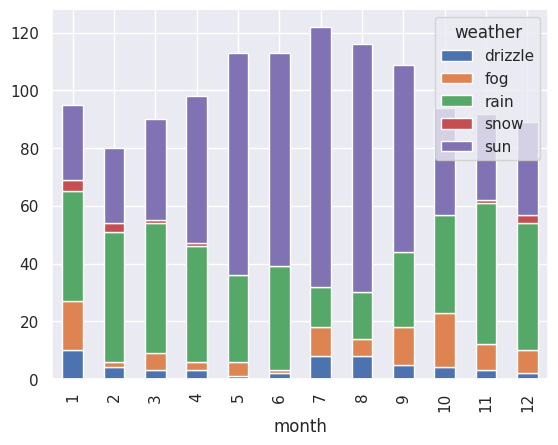

In [ ]:
# monthly weather plots
month_weather = data.groupby(['month'])['weather'].value_counts().unstack().plot(kind='bar',stacked = True)

The consistency in sunny and rainy days indicates a **stable annual weather pattern** over these years. 2015 shows a slight increase in rainy and foggy days, which could indicate a weather anomaly or natural variability.

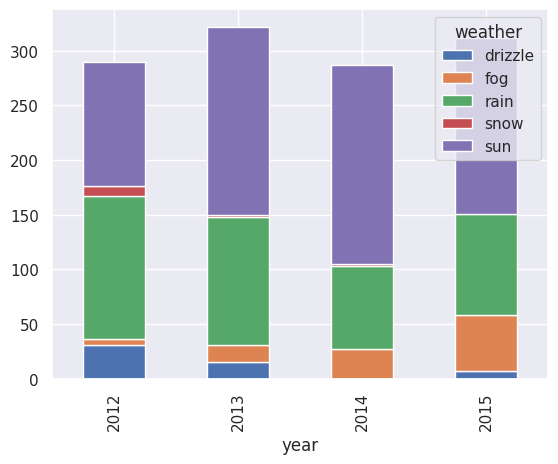

In [ ]:
# annual weather plots
annual_weather = data.groupby(['year'])['weather'].value_counts().unstack().plot(kind='bar',stacked = True)

The clear seasonality in the temperature trend could be an important feature for predictive models, especially when combined with other seasonal variables such as precipitation or weather types. **The data does not show significant year-over-year variations**, indicating a stable climate within this timeframe.

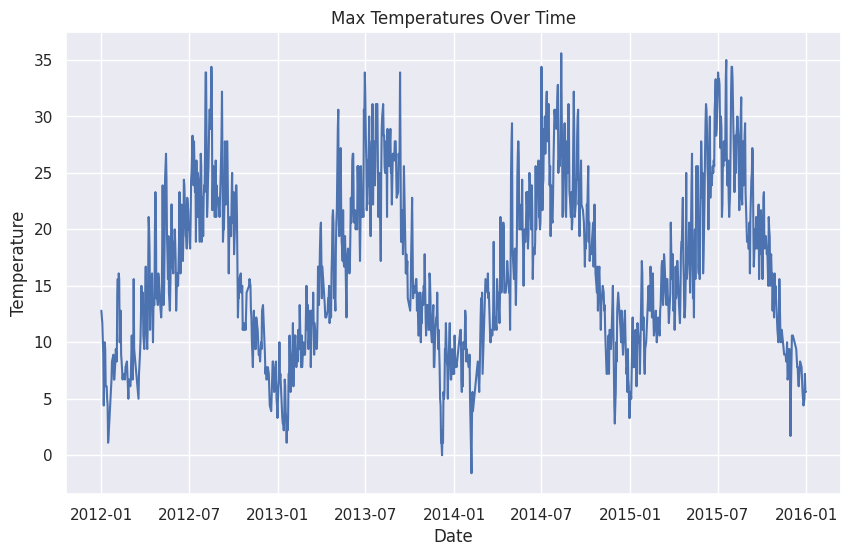

In [ ]:
# time Series Plot: (Max Temperature)
plt.figure(figsize=(10,6))
plt.plot(data['date'], data['temp_max'])
plt.title('Max Temperatures Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()

Thus, **excluding the date-related columns** helps streamline the model, reduce dimensionality, and avoid the risk of overfitting, while focusing on the variables that truly drive predictive performance.
For efficiency, we have decided to drop the date-related columns directly within the data processing pipeline.